In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

from pandas import DataFrame
from initializer import init

%matplotlib inline
plt.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

init()

In [2]:
import utils

# 1. Moving Average 활용 전략

- `BUY`: whenever the shorter SMA start to be above the longer one
- `SELL`: whenever the shorter SMA start to be below the longer one

In [3]:
df: DataFrame = fdr.DataReader("005930", "2010-01-02", "2020-10-30")
df = df[["Close"]]
df.head()

,Close
Date,
2010-01-04,16180
2010-01-05,16440
2010-01-06,16820
2010-01-07,16260
2010-01-08,16420


In [4]:
BUSSINESS_DAY_IN_MONTH = 21

df["SMA_short"] = df["Close"].rolling(BUSSINESS_DAY_IN_MONTH * 6).mean()
df["SMA_long"] = df["Close"].rolling(BUSSINESS_DAY_IN_MONTH * 12).mean()
df = df.dropna()
df.head()

,Close,SMA_short,SMA_long
Date,,,
2011-01-03,19160,16152.063,16083.254
2011-01-04,19160,16181.111,16095.079
2011-01-05,18840,16208.571,16104.603
2011-01-06,18600,16233.175,16111.667
2011-01-07,18420,16253.016,16120.238


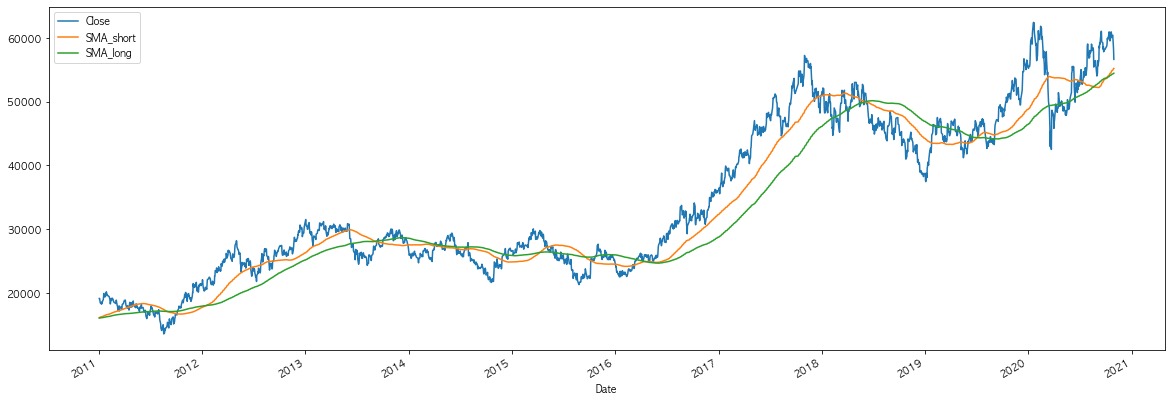

In [5]:
df.plot(figsize=(20, 7));

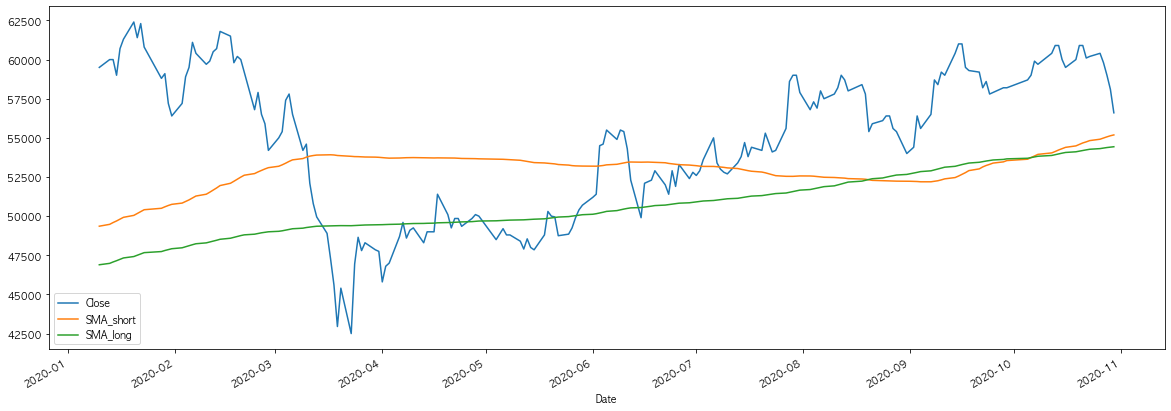

In [6]:
df.iloc[-200:].plot(figsize=(20, 7));

## 1.1. position 구하기

In [8]:
(df["SMA_short"] >= df["SMA_long"]).head()

Date
2011-01-03    True
2011-01-04    True
2011-01-05    True
2011-01-06    True
2011-01-07    True
dtype: bool

In [10]:
np.where(df["SMA_short"] >= df["SMA_long"], 1, 0)
np.where(df["SMA_short"] >= df["SMA_long"], 1, 0).mean()

array([1, 1, 1, ..., 1, 1, 1])

0.6187525815778604

In [12]:
df.loc[:, "position"] = np.where(df["SMA_short"] >= df["SMA_long"], 1, 0)
df["position"].head()

Date
2011-01-03    1
2011-01-04    1
2011-01-05    1
2011-01-06    1
2011-01-07    1
Name: position, dtype: int64

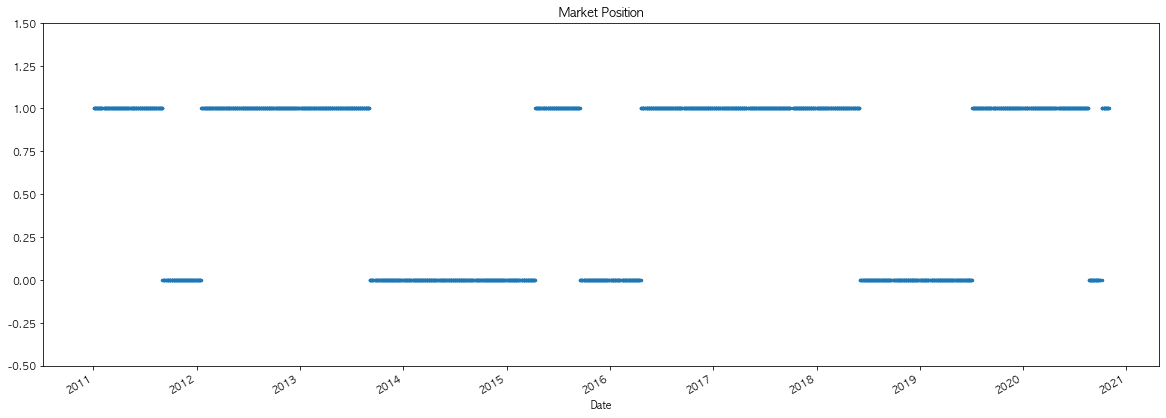

In [16]:
df["position"].plot(
    ylim=[-0.5, 1.5], title="Market Position", figsize=(20, 7), marker=".", markersize=5, linestyle="none"
);

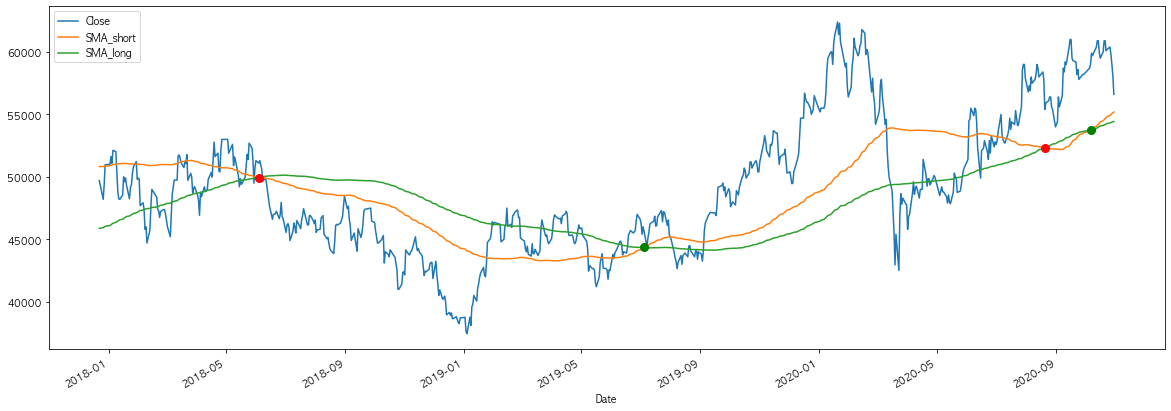

In [21]:
_df = df.iloc[-700:]

exit_index = _df.loc[(_df["position"] - _df["position"].shift()) == -1].index
long_index = _df.loc[(_df["position"] - _df["position"].shift()) == 1].index

ax = _df.drop(["position"], axis=1).plot(figsize=(20, 7))
_df.loc[exit_index, "SMA_short"].plot(ax=ax, marker="o", markersize=8, linestyle="none", color="red")
_df.loc[long_index, "SMA_short"].plot(ax=ax, marker="o", markersize=8, linestyle="none", color="green");

## 1.2. Return 구하기

In [22]:
df.loc[:, "rtn"] = utils.get_returns_df(df["Close"], log=True)

```python
why_are_we = (df["position"].shift(1) * df["rtn"]).fillna(0)
```

- 왜 `shift(1)`을 하는가?
  - 해당 일에 position은 당일 종가를 받아서 이미 moving average 등 모든 계산이 끝난 후에 결정되는 position이다.
  - 따라서 오늘 position을 1로 설정했으면 (다음날 얻는 수익 * 1) 만큼 수익이 발생한다.

> 종가로 positioning을 했으니까 종가에 딱 사면 장이 끝난 거고, 즉 매수 당일에는 수익률이 있다고 볼 수 없다.  
> 그래서 position을 shift 처리 후에 다음 날 수익률으로 표시하는 것이 옳다.

In [23]:
df.loc[:, "strategy_rtn"] = (df["position"].shift(1) * df["rtn"]).fillna(0)

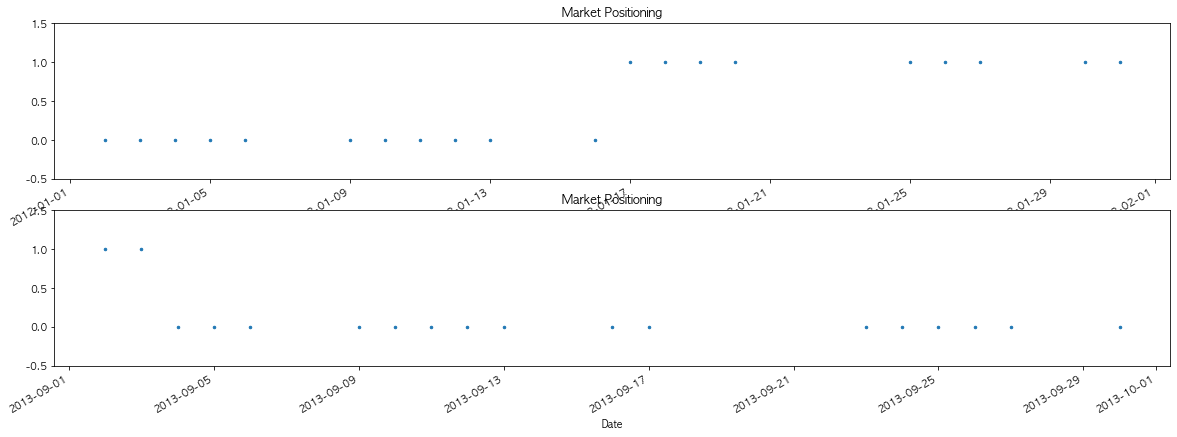

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 15))
df["position"].loc["2012-01"].plot(
    ax=axes[0],
    ylim=[-0.5, 1.5], title="Market Positioning", figsize=(20, 7), marker=".", markersize="5", linestyle="none"
)
df["position"].loc["2013-09"].plot(
    ax=axes[1],
    ylim=[-0.5, 1.5], title="Market Positioning", figsize=(20, 7), marker=".", markersize="5", linestyle="none"
);

In [30]:
df.loc[:, "cum_rtn"] = utils.get_cum_returns_df(df["rtn"], log=True)
df.loc[:, "cum_strategy_rtn"] = utils.get_cum_returns_df(df["strategy_rtn"], log=True)
df.head()

,Close,SMA_short,SMA_long,position,rtn,strategy_rtn,cum_rtn,cum_strategy_rtn
Date,,,,,,,,
2011-01-03,19160,16152.063,16083.254,1,0.000,0.000,1.000,1.000
2011-01-04,19160,16181.111,16095.079,1,0.000,0.000,1.000,1.000
2011-01-05,18840,16208.571,16104.603,1,-0.017,-0.017,0.983,0.983
2011-01-06,18600,16233.175,16111.667,1,-0.013,-0.013,0.971,0.971
2011-01-07,18420,16253.016,16120.238,1,-0.010,-0.010,0.961,0.961


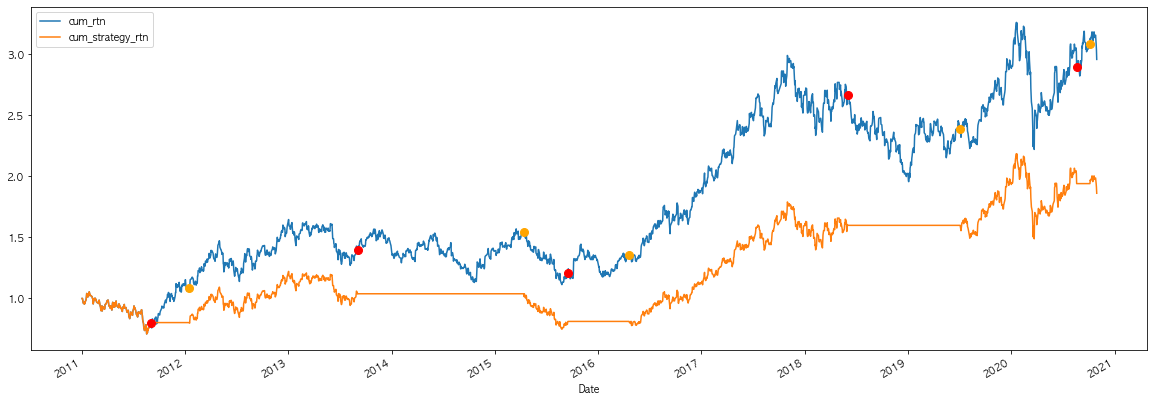

In [32]:
exit_index = df[(df['position'] - df['position'].shift()) == -1].index
long_index = df[(df['position'] - df['position'].shift()) == 1].index

ax = df[['cum_rtn', 'cum_strategy_rtn']].plot(figsize=(20, 7))
df.loc[exit_index, "cum_rtn"].plot(ax=ax, marker="o", markersize=8, linestyle="none", color="red")
df.loc[long_index, "cum_rtn"].plot(ax=ax, marker="o", markersize=8, linestyle="none", color="orange");

## 1.3. Performance 구하기

In [34]:
utils.get_sharpe_ratio(df[["rtn", "strategy_rtn"]]).to_frame("Sharpe Ratio")

,Sharpe Ratio
rtn,0.318
strategy_rtn,0.176


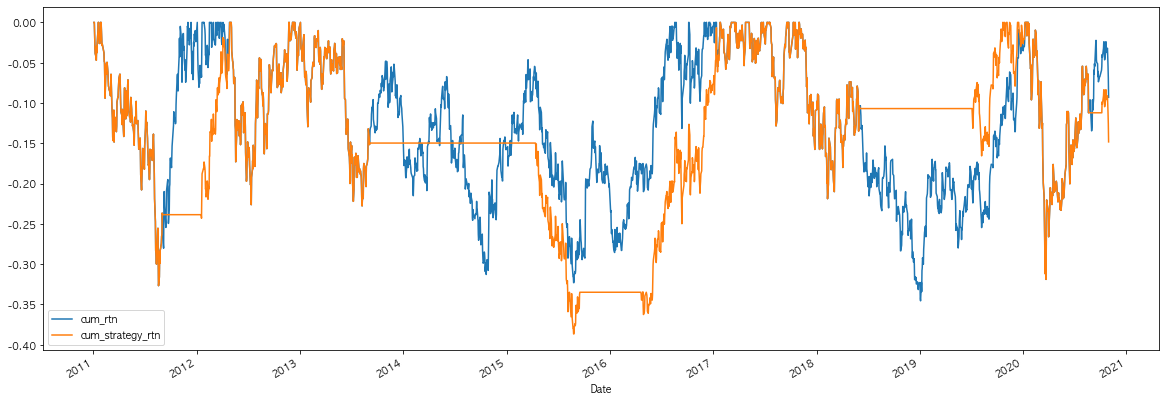

In [35]:
infos = utils.get_drawdown_infos(df.filter(like="cum_"))
infos[0].plot(figsize=(20, 7));

In [36]:
mdd_series = infos[1]
mdd_series.to_frame("MDD")

,MDD
cum_rtn,-0.346
cum_strategy_rtn,-0.387


In [38]:
longest_dd_period_df = infos[2]
longest_dd_period_df

,drawdown mean,drawdown std,longest days,longest period
cum_rtn,36,158,1324,2013-01-02 ~ 2016-08-18
cum_strategy_rtn,49,200,1484,2013-01-02 ~ 2017-01-25


# 2. Momentum 활용 전략

> 물리학에서의 "관성의 법칙"과 유사하다.

- 2 types
  1. Cross-Sectional Momentum(Relative Momentum, 상대적)
  2. Time-Series Momentum(절대적)

In [52]:
df = fdr.DataReader("005930", "2010-01-02", "2020-10-30")
df = df[["Close"]]
df.head()

,Close
Date,
2010-01-04,16180
2010-01-05,16440
2010-01-06,16820
2010-01-07,16260
2010-01-08,16420


## 2.1. Position 구하기

In [53]:
MOMENTUM_WINDOW = 20 * 6 # 6개월

position = np.sign(utils.get_returns_df(df["Close"], N=MOMENTUM_WINDOW))
position.head()
position.value_counts()

Date
2010-06-25    0.000
2010-06-28   -1.000
2010-06-29   -1.000
2010-06-30   -1.000
2010-07-01   -1.000
Name: Close, dtype: float64

1.000     1517
-1.000    1028
0.000        8
Name: Close, dtype: int64

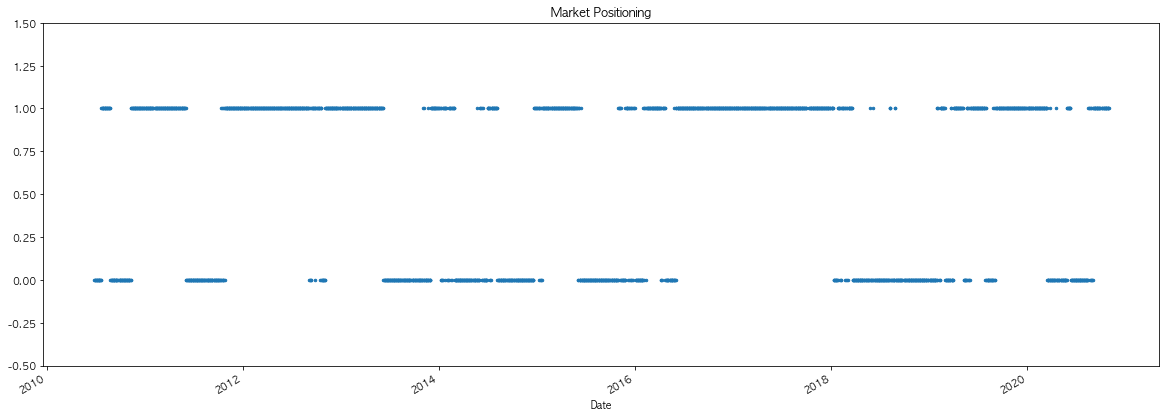

In [54]:
position.loc[position == -1] = 0 # short을 하지 않는다고 가정
position.plot(
    ylim=[-0.5, 1.5], title="Market Positioning", figsize=(20, 7), marker=".", markersize=5, linestyle="none"
);

In [55]:
# 아래 두 데이터의 길이가 다르지만, pandas는 index가 동일하면 알아서 맞춰서 할당한다.
df.shape
position.shape

df.loc[:, "position"] = position
df.head()

# 하지만 NaN값은 버림 ^__^
df = df.dropna()
df.head()

(2672, 1)

(2553,)

,Close,position
Date,,
2010-01-04,16180,NaN
2010-01-05,16440,NaN
2010-01-06,16820,NaN
2010-01-07,16260,NaN
2010-01-08,16420,NaN


,Close,position
Date,,
2010-06-25,16100,0.000
2010-06-28,15920,0.000
2010-06-29,15840,0.000
2010-06-30,15480,0.000
2010-07-01,15320,0.000


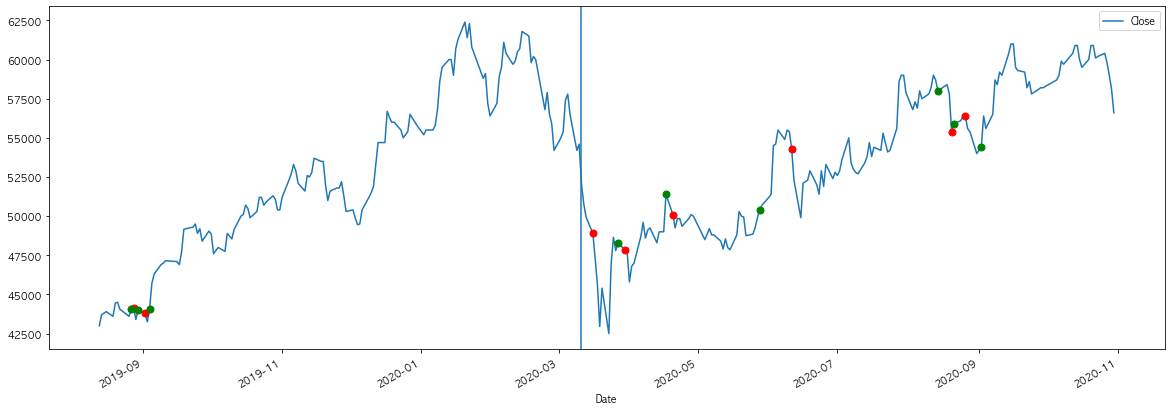

In [65]:
_df = df.iloc[-300:]

exit_index = _df[(_df["position"] - _df["position"].shift()) == -1].index
long_index = _df[(_df["position"] - _df["position"].shift()) == 1].index

ax = _df.drop(["position"], axis=1).plot(figsize=(20, 7))
_df.loc[exit_index, "Close"].plot(ax=ax, marker="o", markersize=7, linestyle="none", color="red")
_df.loc[long_index, "Close"].plot(ax=ax, marker="o", markersize=7, linestyle="none", color="green")

# df.index.get_loc("2020-09-02") - 120 => 마지막 매수 시점으로부터 120일 전 세로축(vertical) 라인
ax.axvline(df.index[df.index.get_loc("2020-09-02") - 120]);

## 2.2. Return 구하기

In [67]:
df.loc[:, "rtn"] = utils.get_returns_df(df["Close"], log=True)
df.loc[:, "strategy_rtn"] = (df["position"].shift(1) * df["rtn"]).fillna(0)

df.loc[:, "cum_rtn"] = utils.get_cum_returns_df(df["rtn"], log=True)
df.loc[:, "cum_strategy_rtn"] = utils.get_cum_returns_df(df["strategy_rtn"], log=True)

df.head()

,Close,position,rtn,strategy_rtn,cum_rtn,cum_strategy_rtn
Date,,,,,,
2010-06-25,16100,0.000,0.000,0.000,1.000,1.000
2010-06-28,15920,0.000,-0.011,-0.000,0.989,1.000
2010-06-29,15840,0.000,-0.005,-0.000,0.984,1.000
2010-06-30,15480,0.000,-0.023,-0.000,0.961,1.000
2010-07-01,15320,0.000,-0.010,-0.000,0.952,1.000


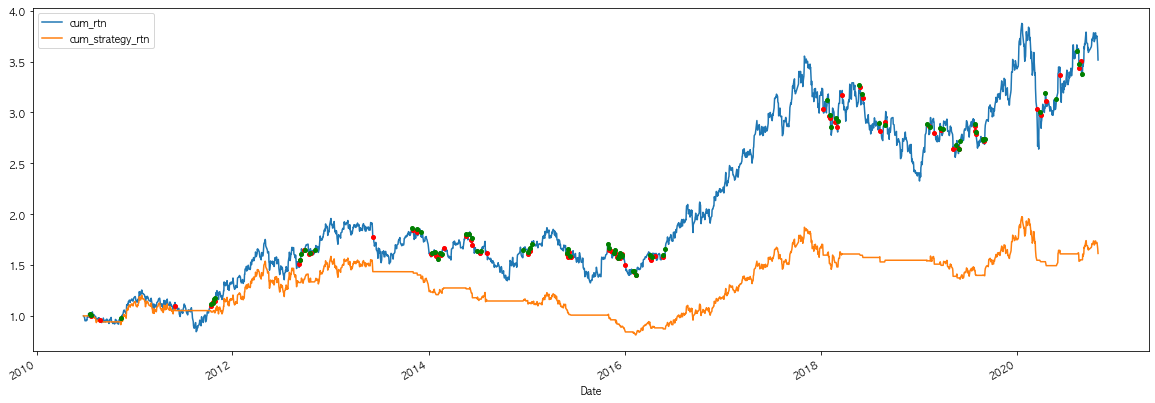

In [70]:
exit_index = df[(df["position"] - df["position"].shift()) == -1].index
long_index = df[(df["position"] - df["position"].shift()) == 1].index

ax = df[["cum_rtn", "cum_strategy_rtn"]].plot(figsize=(20, 7))
df.loc[exit_index, "cum_rtn"].plot(ax=ax, marker="o", markersize=4, linestyle="none", color="red")
df.loc[long_index, "cum_rtn"].plot(ax=ax, marker="o", markersize=4, linestyle="none", color="green");

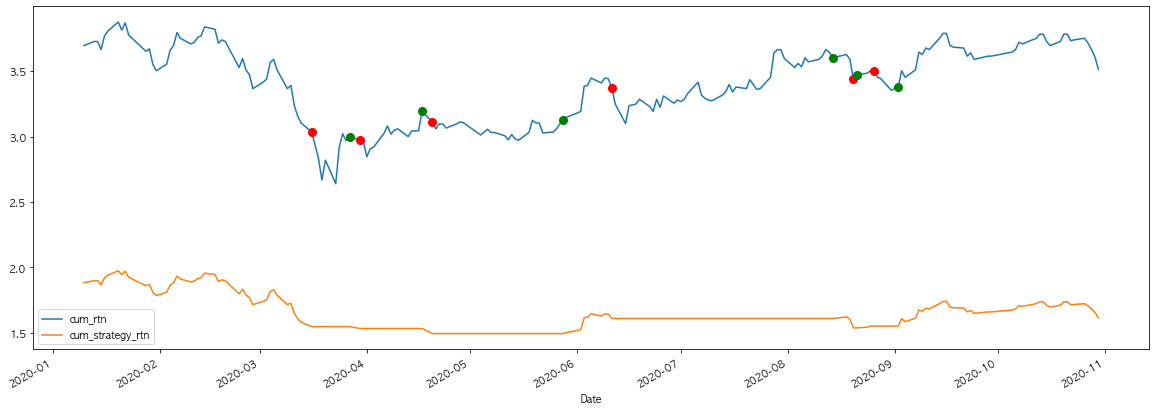

In [72]:
_df = df.iloc[-200:]

exit_index = _df[(_df['position'] - _df['position'].shift()) == -1].index
long_index = _df[(_df['position'] - _df['position'].shift()) == 1].index

ax = _df[['cum_rtn', 'cum_strategy_rtn']].plot(figsize=(20, 7));
_df.loc[exit_index, "cum_rtn"].plot(ax=ax, marker="o", markersize=8, linestyle="none", color="red");
_df.loc[long_index, "cum_rtn"].plot(ax=ax, marker="o", markersize=8, linestyle="none", color="green"); 

- Multiple Momentum Window Test

In [73]:
df = fdr.DataReader("005930", '2010-01-02', '2020-10-30')
df = df[['Close']]
df.loc[:, 'rtn'] = utils.get_returns_df(df['Close'], log=True)

rtn_column_list = ["rtn"]
momentum_list = [1*20, 3*20, 5*20]
for momentum_window in momentum_list:
    position = np.sign(utils.get_returns_df(df['Close'], N=momentum_window))
    position.loc[position == -1] = 0

    df.loc[:, 'position_{}'.format(momentum_window)] = position
    df = df.dropna()
    df.loc[:, 'strategy_{}_rtn'.format(momentum_window)] = (
        df['position_{}'.format(momentum_window)].shift(1) * df['rtn']
    ).fillna(0)
    rtn_column_list.append('strategy_{}_rtn'.format(momentum_window))

df.head()

,Close,rtn,position_20,strategy_20_rtn,position_60,strategy_60_rtn,position_100,strategy_100_rtn
Date,,,,,,,,
2010-09-15,15140,-0.004,0.000,-0.000,0.000,-0.000,0.000,0.000
2010-09-16,15140,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2010-09-17,15460,0.021,0.000,0.000,0.000,0.000,0.000,0.000
2010-09-20,15600,0.009,0.000,0.000,0.000,0.000,0.000,0.000
2010-09-24,15240,-0.023,0.000,-0.000,0.000,-0.000,0.000,-0.000


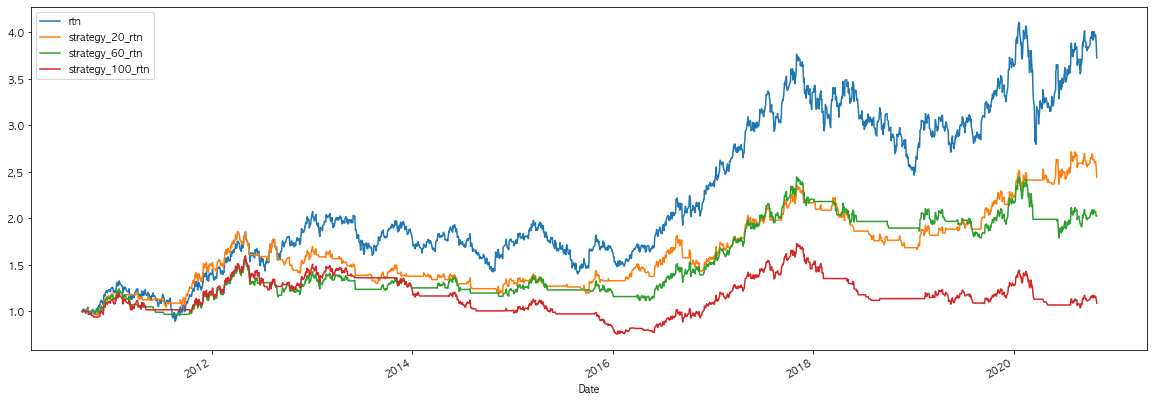

In [76]:
rtn_column_list

cum_rtn_df = utils.get_cum_returns_df(df[rtn_column_list], log=True)
cum_rtn_df.plot(figsize=(20, 7));

## 2.3. Performance 구하기

In [79]:
utils.get_sharpe_ratio(df[rtn_column_list]).to_frame("Sharpe Ratio")

,Sharpe Ratio
rtn,0.392
strategy_20_rtn,0.327
strategy_60_rtn,0.229
strategy_100_rtn,-0.080


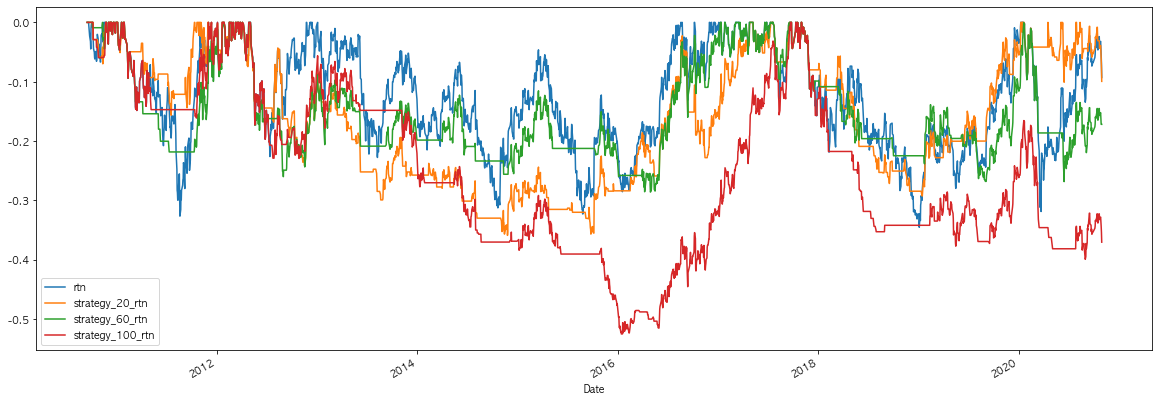

In [82]:
dd_df, mdd_series, longest_dd_period_df = utils.get_drawdown_infos(cum_rtn_df)
dd_df.plot(figsize=(20, 7));

In [83]:
mdd_series.to_frame("MDD")

,MDD
rtn,-0.346
strategy_20_rtn,-0.359
strategy_60_rtn,-0.286
strategy_100_rtn,-0.525


In [84]:
longest_dd_period_df

,drawdown mean,drawdown std,longest days,longest period
rtn,30,144,1324,2013-01-02 ~ 2016-08-18
strategy_20_rtn,38,205,1850,2012-04-03 ~ 2017-04-27
strategy_60_rtn,40,211,1713,2012-05-02 ~ 2017-01-09
strategy_100_rtn,58,280,1969,2012-05-02 ~ 2017-09-22


In [85]:
utils.get_CAGR_series(cum_rtn_df).to_frame("CAGR")

,CAGR
rtn,0.141
strategy_20_rtn,0.094
strategy_60_rtn,0.073
strategy_100_rtn,0.009


> ***결국 `position`을 어떻게 뽑아내느냐가 중요하다.***

In [88]:
"""10%를 더 빼서 강한 signal을 도출하는 방법"""
position = np.sign(utils.get_returns_df(df["Close"], N=MOMENTUM_WINDOW) - 0.1)
position

'10%를 더 빼서 강한 signal을 도출하는 방법'

Date
2011-03-11   -1.000
2011-03-14    1.000
2011-03-15    1.000
2011-03-16    1.000
2011-03-17    1.000
              ...  
2020-10-26    1.000
2020-10-27    1.000
2020-10-28    1.000
2020-10-29    1.000
2020-10-30    1.000
Name: Close, Length: 2376, dtype: float64

# 3. Mean Reversion - 평균 회귀 활용 전략

> Bollinger Band 활용

> Momentum 전략은 과거의 추세에 따라 현재의 추세가 따라갈 것이라고 전제하는 것.  
> Mean Reversion 전략은 그 때 올랐으면, 이제 떨어지겠지 하는 전략.

In [109]:
df = fdr.DataReader("005930", "2010-01-02", "2020-10-30")
df = df[["Close"]]
df.head()

,Close
Date,
2010-01-04,16180
2010-01-05,16440
2010-01-06,16820
2010-01-07,16260
2010-01-08,16420


In [110]:
WINDOW = 60

df.loc[:, "SMA"] = df["Close"].rolling(WINDOW).mean()
rolling_std = df["Close"].rolling(WINDOW).std()

df = df.dropna()

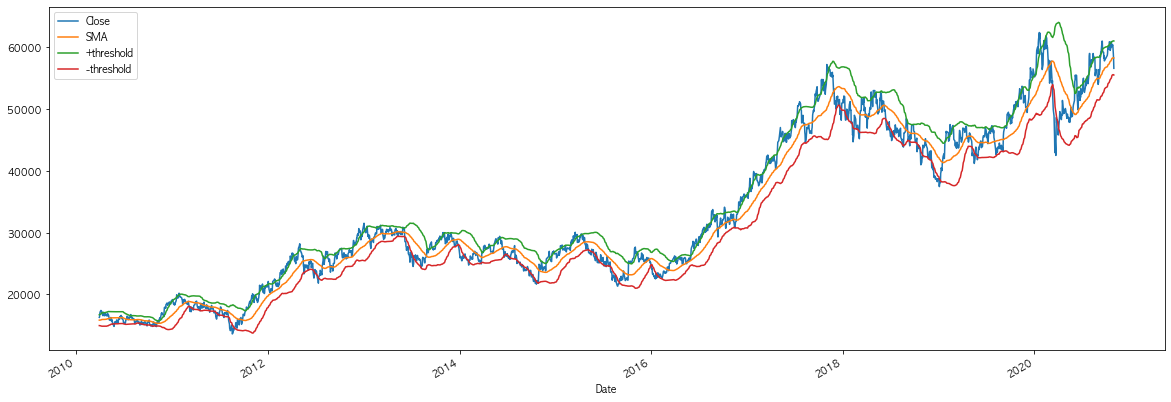

In [111]:
df["+threshold"] = df["SMA"] + 1.5 * rolling_std
df["-threshold"] = df["SMA"] - 1.5 * rolling_std

df[["Close", "SMA", "+threshold", "-threshold"]].plot(figsize=(20, 7));

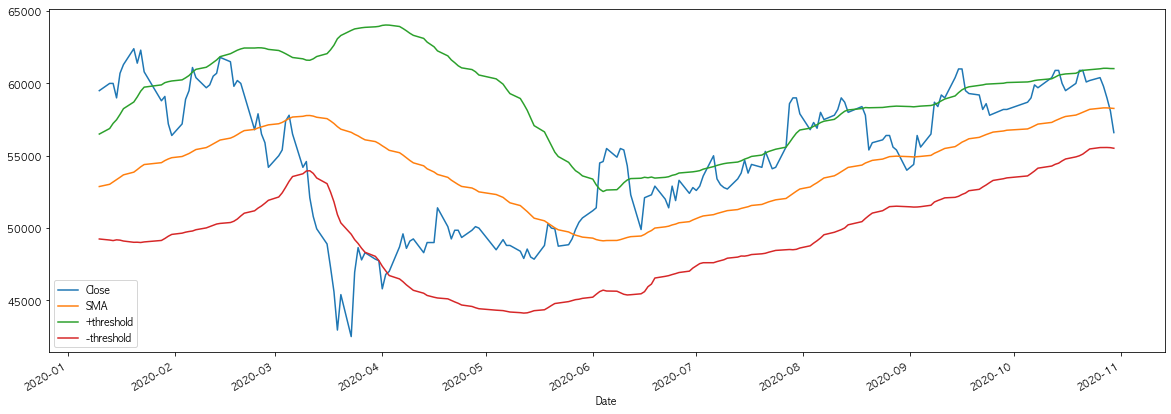

In [113]:
df[["Close", "SMA", "+threshold", "-threshold"]].iloc[-200:].plot(figsize=(20, 7));

## 3.1. Position 구하기

In [114]:
pos1 = np.where(df["Close"] <= df["-threshold"], 1, 0)
pos2 = np.where(df["Close"] >= df["+threshold"], -1, 0)
df.loc[:, "position"] = pos1 + pos2
df.head()

,Close,SMA,+threshold,-threshold,position
Date,,,,,
2010-03-30,16280,15831.333,16710.297,14952.370,0
2010-03-31,16360,15834.333,16716.705,14951.962,0
2010-04-01,16900,15842.000,16740.757,14943.243,-1
2010-04-02,17140,15847.333,16761.376,14933.291,-1
2010-04-05,17400,15866.333,16825.546,14907.120,-1


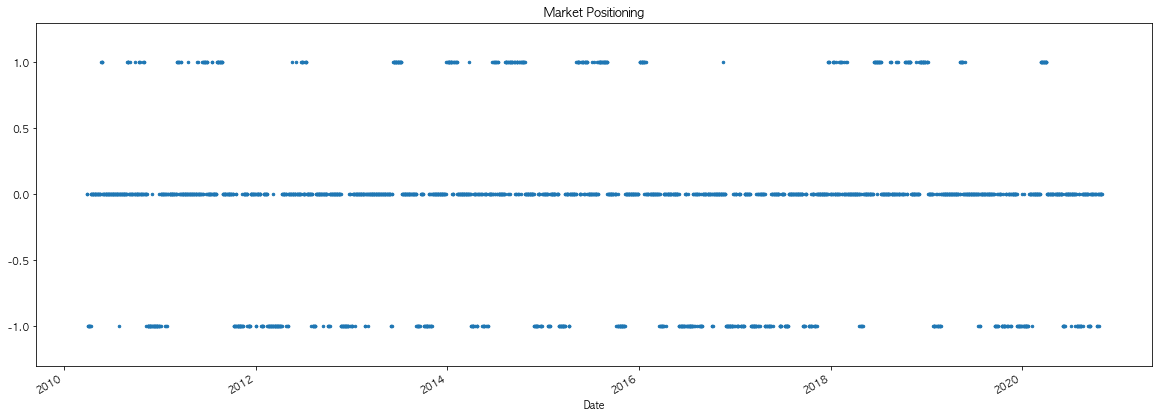

In [116]:
df["position"].plot(
    ylim=[-1.3, 1.3], title="Market Positioning", figsize=(20, 7), marker=".", markersize=5, linestyle="none"
);

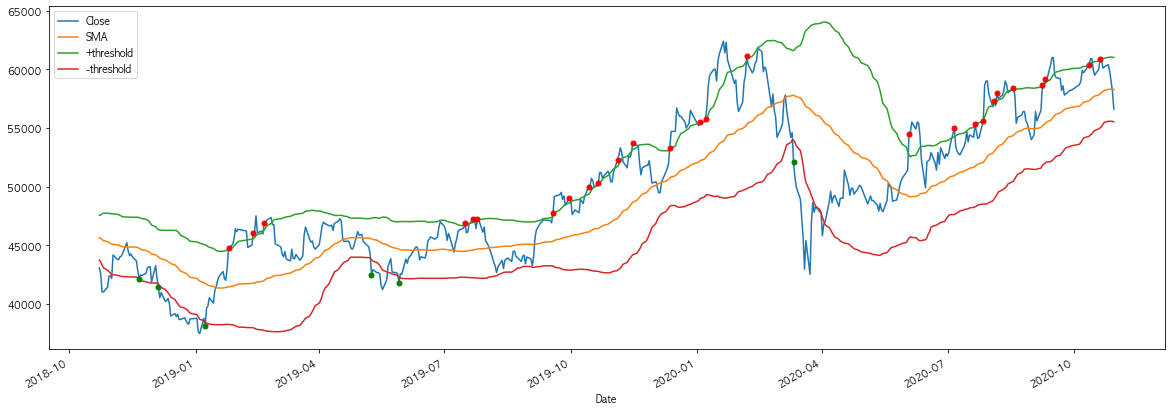

In [118]:
_df = df.iloc[-500:]

short_index = _df[
    ((_df['position'] - _df['position'].shift()) == -1) & (_df['position'] == -1)
].index
long_index = _df[
    ((_df['position'] - _df['position'].shift()) == 1) & (_df['position'] == 1)
].index

ax = _df[['Close', 'SMA', '+threshold', '-threshold']].plot(figsize=(20, 7))
_df.loc[short_index, "Close"].plot(ax=ax, marker="o", markersize=5, linestyle="none", color="red")
_df.loc[long_index, "Close"].plot(ax=ax, marker="o", markersize=5, linestyle="none", color="green");

## 3.2. Return 구하기

In [119]:
df['rtn'] = utils.get_returns_df(df['Close'], log=True)
df['strategy_rtn'] = (df['position'].shift(1) * df['rtn']).fillna(0)

In [120]:
df.loc[:, 'cum_rtn'] = utils.get_cum_returns_df(df['rtn'], log=True)
df.loc[:, 'cum_strategy_rtn'] = utils.get_cum_returns_df(df['strategy_rtn'], log=True)

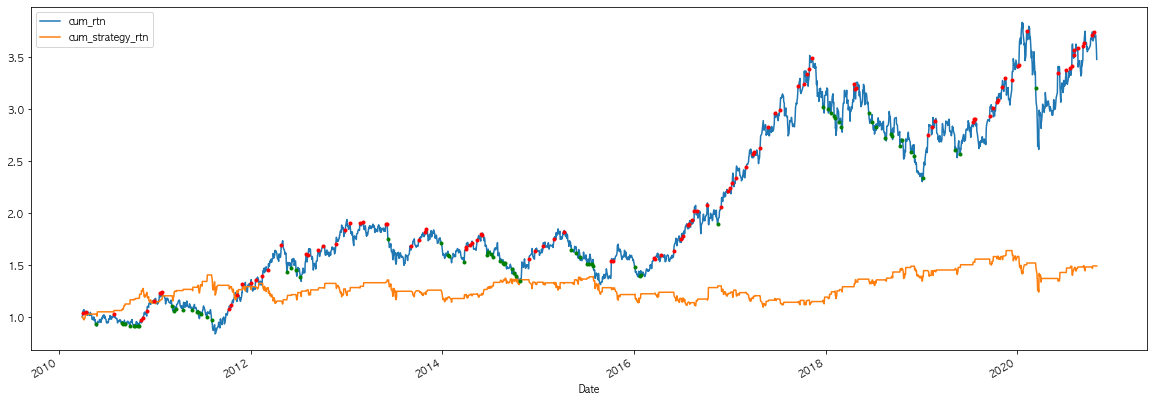

In [121]:
short_index = df[
    ((df['position'] - df['position'].shift()) == -1) & (df['position'] == -1)
].index
long_index = df[
    ((df['position'] - df['position'].shift()) == 1) & (df['position'] == 1)
].index

ax = df[['cum_rtn', 'cum_strategy_rtn']].plot(figsize=(20, 7))
df.loc[short_index, "cum_rtn"].plot(ax=ax, marker="o", markersize=3, linestyle="none", color="red")
df.loc[long_index, "cum_rtn"].plot(ax=ax, marker="o", markersize=3, linestyle="none", color="green");

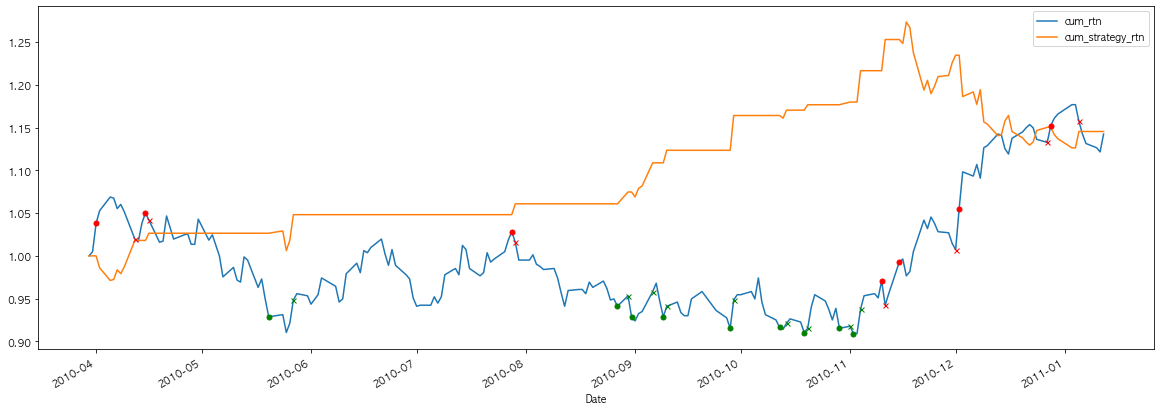

In [123]:
_df = df.iloc[:200]

short_index = _df[
    ((_df['position'] - _df['position'].shift()) == -1) & (_df['position'] == -1)
].index
long_index = _df[
    ((_df['position'] - _df['position'].shift()) == 1) & (_df['position'] == 1)
].index

short_exit_index = _df[
    ((_df['position'] - _df['position'].shift()) == 1) & (_df['position'] == 0)
].index
long_exit_index = _df[
    ((_df['position'] - _df['position'].shift()) == -1) & (_df['position'] == 0)
].index

ax = _df[['cum_rtn', 'cum_strategy_rtn']].plot(figsize=(20, 7))

_df.loc[short_index, "cum_rtn"].plot(ax=ax, marker="o", markersize=5, linestyle="none", color="red")
_df.loc[short_exit_index, "cum_rtn"].plot(ax=ax, marker="x", markersize=5, linestyle="none", color="red")

_df.loc[long_index, "cum_rtn"].plot(ax=ax, marker="o", markersize=5, linestyle="none", color="green")
_df.loc[long_exit_index, "cum_rtn"].plot(ax=ax, marker="x", markersize=5, linestyle="none", color="green");

## 3.3. Performance 구하기

In [125]:
utils.get_sharpe_ratio(df[['rtn', 'strategy_rtn']]).to_frame("Sharpe Ratio")

,Sharpe Ratio
rtn,0.348
strategy_rtn,0.081


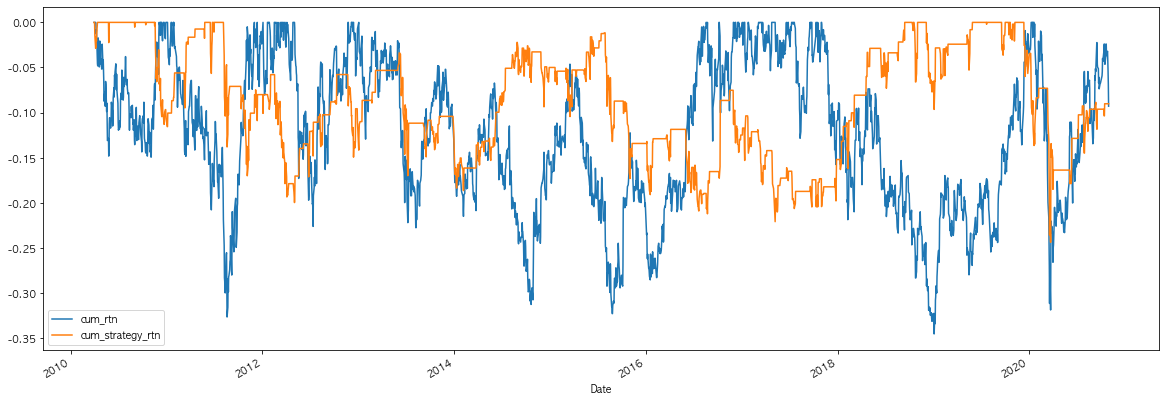

In [126]:
dd_df, mdd_series, longest_dd_period_df = utils.get_drawdown_infos(df.filter(like="cum_"))
dd_df.plot(figsize=(20, 7));

In [127]:
mdd_series.to_frame("MDD")

,MDD
cum_rtn,-0.346
cum_strategy_rtn,-0.244


In [128]:
longest_dd_period_df

,drawdown mean,drawdown std,longest days,longest period
cum_rtn,33,149,1324,2013-01-02 ~ 2016-08-18
cum_strategy_rtn,11,141,2597,2011-08-05 ~ 2018-09-14


In [129]:
utils.get_CAGR_series(df.filter(like="cum_")).to_frame("CAGR")

,CAGR
cum_rtn,0.127
cum_strategy_rtn,0.039
